## 1. Import pakages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import plotly
import chart_studio.plotly as py
import plotly.express as px
import cufflinks as cf
cf.go_offline()

import os
import tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import lightgbm as lgb

In [2]:
plt.rcParams['font.sans-serif']=['SimHei'] #用來正常顯示中文標簽
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號

## 2. Data reading and preprocessing

In [3]:
path_data = r'C:\Users\patri\Taipower\data'

path_data_loadarea = os.path.join(path_data, 'loadarea')
path_data_forecast = os.path.join(path_data, 'forecast')

### 2.1 Energy data

In [4]:
loadarea = pd.DataFrame()

for file in tqdm.tqdm(os.listdir(path_data_loadarea)):
    df_temp = pd.read_csv(os.path.join(path_data_loadarea, file))
    loadarea = pd.concat([loadarea, df_temp], axis=0, ignore_index=True)

loadarea = loadarea.pivot_table(columns='area',index='datetime',values='load')
loadarea.index= pd.to_datetime(loadarea.index)
loadarea.columns = 'load_'+loadarea.columns

loadarea['load_total'] = loadarea['load_north']+ loadarea['load_east']+ loadarea['load_central']+ loadarea['load_south']

100%|██████████████████████████████████████████████████████████████████████████████| 1946/1946 [00:21<00:00, 88.87it/s]


### 2.2 Weather data

In [5]:
weatherData = pd.read_csv(os.path.join(path_data, 'weatherData_20170101-20220701.csv'), encoding='utf8')
temperatureData = weatherData.pivot_table(index='ObsTime',columns='station',values='Temperature')
temperatureData = temperatureData.rename(columns={'466920_臺北':'Taipei','466990_花蓮':'Hualien',
                                                  '467410_臺南':'Tainan','467490_臺中':'Taichung'})
temperatureData.index = pd.to_datetime(temperatureData.index)
temperatureData.columns = 'temperature_'+temperatureData.columns
temperatureData = temperatureData.resample('D').agg(['max','min','mean'])
temperatureData.columns = temperatureData.columns.get_level_values(0)+'_'+temperatureData.columns.get_level_values(1)

### 2.3 Calendar data

In [6]:
url = 'https://data.ntpc.gov.tw/api/datasets/308DCD75-6434-45BC-A95F-584DA4FED251/csv/file'
df_holiday = pd.read_csv(url)
df_holiday = df_holiday.rename(columns={'name':'holiday_name', 'description':'holiday_description'})

In [7]:
df_holiday['date'] = pd.to_datetime(df_holiday['date'])
df_holiday = df_holiday.set_index('date').asfreq('D')
df_holiday = df_holiday.reset_index()

df_holiday['holiday_name'] = preprocessing.LabelEncoder().fit_transform(df_holiday['holiday_name'].astype('str'))
df_holiday['isHoliday'] = preprocessing.LabelEncoder().fit_transform(df_holiday['isHoliday'].astype('str'))
df_holiday['holidayCategory'] = preprocessing.LabelEncoder().fit_transform(df_holiday['holidayCategory'].astype('str'))
df_holiday['holiday_description'] = preprocessing.LabelEncoder().fit_transform(df_holiday['holiday_description'].astype('str'))

### 2.4 Merge datasets and create features

In [8]:
df_dataset = loadarea.copy()


index_temp = df_dataset.index.copy()

df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData.reset_index(), left_on='date', right_on='ObsTime')
df_dataset = df_dataset.merge(df_holiday, on='date')
df_dataset = df_dataset.drop('date',axis=1)
df_dataset.index = index_temp

df_dataset['temperature_mean']=df_dataset[['temperature_Taipei_mean', 'temperature_Tainan_mean', 'temperature_Taichung_mean']].mean(axis=1)

## 3. Modeling

In [9]:
growth_rate = 0.025

In [10]:
df_dataset['delta_time'] = df_dataset.index.year + df_dataset.index.dayofyear/366 + df_dataset.index.hour/366/24
df_dataset['delta_time'] = df_dataset['delta_time'] - df_dataset['delta_time'].min()

df_dataset['load_total_untrended'] = df_dataset['load_total'] * (1-growth_rate*df_dataset['delta_time'])

In [11]:
df_dataset['load_total_untrended_lastDay'] = df_dataset['load_total_untrended'].shift(24*6)

In [12]:
list_feat = ['weekday','hour','temperature_mean', 
             'holiday_name','isHoliday','holidayCategory',
             'load_total_untrended_lastDay']

R SQUARED: 0.981
MAE: 40.357


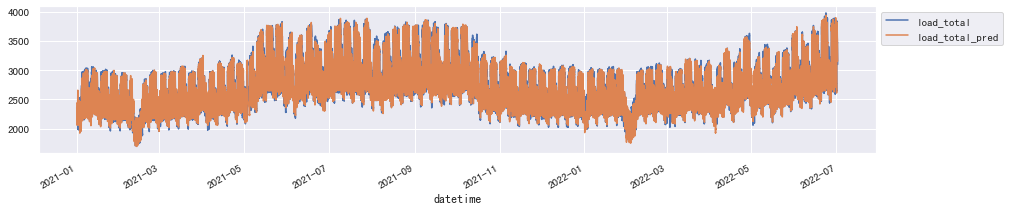

In [13]:
traindata = df_dataset.loc[:'2020'].copy()
testdata = df_dataset.loc['2021':].copy()


LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['load_total_untrended'])

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])
testdata['load_total_pred'] = testdata['load_total_pred'] / (1-growth_rate*testdata['delta_time'])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

## 4. Load forecasting based on 24hr weather forecast

URL of weather forcasting: https://www.cwb.gov.tw/V8/C/W/County/MOD/wf7dayNC_NCSEI/ALL_Week.html

In [14]:
weatherData_forecast = []

for file_name in tqdm.tqdm(os.listdir(path_data_forecast)):
    if file_name.endswith('daily_weather_pred.csv'):
        df_temp = pd.read_csv(os.path.join(path_data_forecast, file_name))
        df_temp['date_pred'] = file_name.split('_')[0]        
        weatherData_forecast.append(df_temp)

weatherData_forecast = pd.concat(weatherData_forecast, axis=0, ignore_index=True)
weatherData_forecast = weatherData_forecast.dropna()
weatherData_forecast['Date'] = pd.to_datetime(weatherData_forecast['Date'])
weatherData_forecast['date_pred'] = pd.to_datetime(weatherData_forecast['date_pred'])

weatherData_forecast = weatherData_forecast[(weatherData_forecast['Date']-weatherData_forecast['date_pred']).dt.days==1]
weatherData_forecast = weatherData_forecast.drop('date_pred',axis=1)

weatherData_forecast = weatherData_forecast.melt(id_vars=['縣市', '時間', 'Date'])
weatherData_forecast = weatherData_forecast.pivot_table(index='Date',columns='縣市',values='value',aggfunc='mean')
weatherData_forecast.columns = 'Forecasting_temperature_'+weatherData_forecast.columns

weatherData_forecast = weatherData_forecast[['Forecasting_temperature_臺中市', 
                                             'Forecasting_temperature_臺北市', 
                                             'Forecasting_temperature_臺南市']]

weatherData_forecast = weatherData_forecast.reset_index()

weatherData_forecast

100%|████████████████████████████████████████████████████████████████████████████| 1466/1466 [00:00<00:00, 1882.11it/s]


縣市,Date,Forecasting_temperature_臺中市,Forecasting_temperature_臺北市,Forecasting_temperature_臺南市
0,2021-05-19,30.75,29.50,30.25
1,2021-05-20,31.25,30.50,30.00
2,2021-05-21,31.25,30.25,30.50
3,2021-05-22,30.25,28.25,29.75
4,2021-05-23,30.50,28.75,29.75
...,...,...,...,...
358,2022-07-01,29.25,29.50,29.75
359,2022-07-02,28.50,28.50,28.00
360,2022-07-03,28.50,28.50,28.50
361,2022-07-04,29.00,29.25,28.75


R SQUARED: 0.982
MAE: 42.117


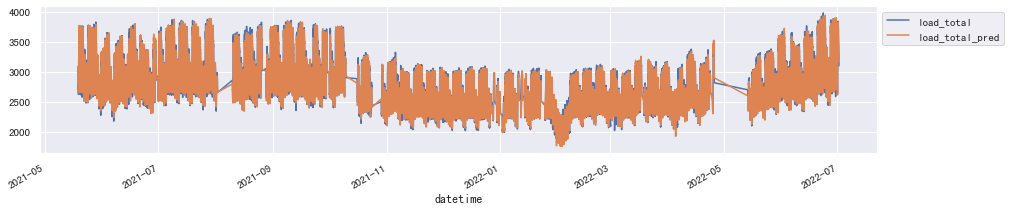

In [15]:
testdata = df_dataset.reset_index().copy()
testdata = testdata.merge(weatherData_forecast,left_on='ObsTime',right_on='Date')
testdata = testdata.set_index('datetime')

testdata['temperature_mean']=testdata[['Forecasting_temperature_臺北市', 'Forecasting_temperature_臺南市', 'Forecasting_temperature_臺中市']].mean(axis=1)

testdata['load_total_pred'] = LGB_model.predict(testdata[list_feat])
testdata['load_total_pred'] = testdata['load_total_pred'] / (1-growth_rate*testdata['delta_time'])

errors = abs(testdata['load_total_pred'] - testdata['load_total'])

RSQUARED = r2_score(testdata['load_total'], testdata['load_total_pred'])
MAE = mean_absolute_error(testdata['load_total'], testdata['load_total_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))

#testdata[['load_total', 'load_total_pred']].iplot()
testdata[['load_total', 'load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

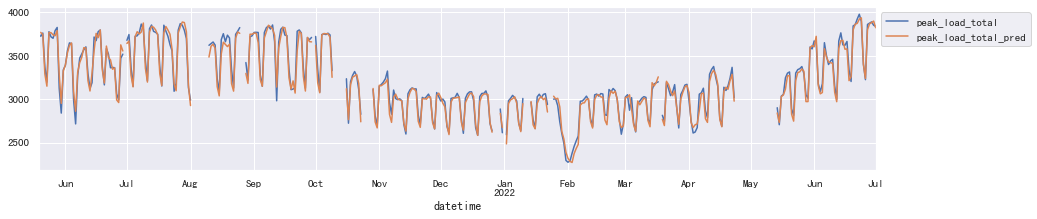

In [16]:
testdata_peak = testdata[['load_total', 'load_total_pred']].resample('D').max()
testdata_peak.columns = 'peak_'+testdata_peak.columns
#testdata_peak.iplot()
testdata_peak.plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

## 5. Comparison with forecasting from Taipower (台電)

URL of demand forcasting: 

https://www.taipower.com.tw/d006/loadGraph/loadGraph/load_forecast_.html

https://www.taipower.com.tw/d006/loadGraph/loadGraph/data/reserve_forecast.txt

### 5.1 Dataset of Taipower forecasting

In [17]:
load_pred = []

for filename in tqdm.tqdm(os.listdir(path_data_forecast)):
    if filename.endswith('_weekly_load_pred.csv'):
        df_temp = pd.read_csv(os.path.join(path_data_forecast, filename))
        df_temp['date_pred'] = filename.split('_')[0]
        df_temp = df_temp.rename(columns={'0':'日期(年/月/日)', 
                                          '1':'預估淨尖峰供電能力(萬瓩)', 
                                          '2':'預估瞬時尖峰負載(萬瓩)', 
                                          '3':'預估尖峰備轉容量率(%)', 
                                          '4':'預估尖峰備轉容量(萬瓩)'})
        load_pred.append(df_temp)

load_pred = pd.concat(load_pred, axis=0, ignore_index=True)
load_pred = load_pred.dropna()
load_pred['日期(年/月/日)'] = pd.to_datetime(load_pred['日期(年/月/日)'])
load_pred['date_pred'] = pd.to_datetime(load_pred['date_pred'])


load_pred

100%|████████████████████████████████████████████████████████████████████████████| 1466/1466 [00:00<00:00, 1647.85it/s]


,日期(年/月/日),預估淨尖峰供電能力(萬瓩),預估瞬時尖峰負載(萬瓩),預估尖峰備轉容量率(%),預估尖峰備轉容量(萬瓩),date_pred
0,2021-05-13,3966.0,3600.0,10.17,366.0,2021-05-12
1,2021-05-14,3964.0,3600.0,10.10,364.0,2021-05-12
2,2021-05-15,3537.0,3200.0,10.52,337.0,2021-05-12
3,2021-05-16,3436.0,3100.0,10.84,336.0,2021-05-12
4,2021-05-17,3895.0,3540.0,10.03,355.0,2021-05-12
...,...,...,...,...,...,...
2947,2022-07-08,4322.0,3880.0,11.39,442.0,2022-07-04
2948,2022-07-09,4167.0,3450.0,20.79,717.0,2022-07-04
2949,2022-07-10,3668.0,3270.0,12.17,398.0,2022-07-04
2950,2022-07-11,4339.0,3880.0,11.82,459.0,2022-07-04


R SQUARED (Taipower): 0.972
MAE (Taipower): 47.091


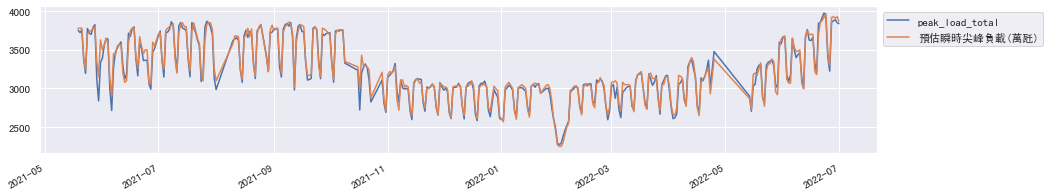

In [18]:
load_pred = load_pred[(load_pred['日期(年/月/日)']-load_pred['date_pred']).dt.days==1]
load_pred = load_pred.set_index('日期(年/月/日)')
load_pred = load_pred.drop('date_pred',axis=1)
load_pred = load_pred.merge(testdata_peak,left_index=True,right_index=True)
load_pred = load_pred.dropna()

R2_taipower = r2_score(load_pred['peak_load_total'], load_pred['預估瞬時尖峰負載(萬瓩)'])
MSE_taipower = mean_absolute_error(load_pred['peak_load_total'], load_pred['預估瞬時尖峰負載(萬瓩)'])

print("R SQUARED (Taipower): "+str(round(R2_taipower,3)))
print("MAE (Taipower): "+str(round(MSE_taipower,3)))
#load_pred[['peak_load_total','預估瞬時尖峰負載(萬瓩)']].iplot()
load_pred[['peak_load_total','預估瞬時尖峰負載(萬瓩)']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

R SQUARED (proposed): 0.975
MAE (proposed): 46.966


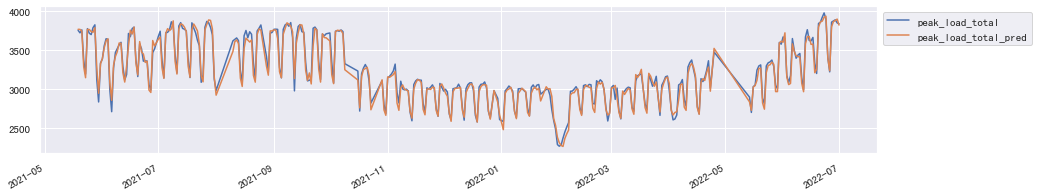

In [19]:
R2_proposed = r2_score(load_pred['peak_load_total'], load_pred['peak_load_total_pred'])
MSE_proposed = mean_absolute_error(load_pred['peak_load_total'], load_pred['peak_load_total_pred'])

print("R SQUARED (proposed): "+str(round(R2_proposed,3)))
print("MAE (proposed): "+str(round(MSE_proposed,3)))

#load_pred[['peak_load_total', 'peak_load_total_pred']].iplot()
load_pred[['peak_load_total', 'peak_load_total_pred']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

R SQUARED (proposed+Taipower): 0.982
MAE (proposed+Taipower): 39.095


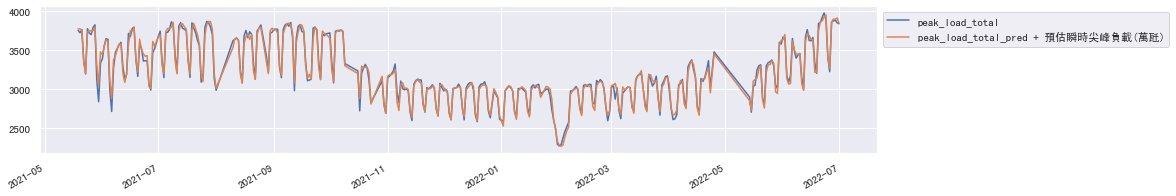

In [20]:
load_pred['peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)'] = load_pred[['預估瞬時尖峰負載(萬瓩)','peak_load_total_pred']].mean(axis=1)

R2_proposed_taipower = r2_score(load_pred['peak_load_total'], load_pred['peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)'])
MSE_proposed_taipower = mean_absolute_error(load_pred['peak_load_total'], load_pred['peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)'])

print("R SQUARED (proposed+Taipower): "+str(round(R2_proposed_taipower,3)))
print("MAE (proposed+Taipower): "+str(round(MSE_proposed_taipower,3)))

#load_pred[['peak_load_total', 'peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)']].iplot()
load_pred[['peak_load_total', 'peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)']].plot(figsize=(15,3))
plt.legend(bbox_to_anchor=(1.00, 1.00))

<AxesSubplot:title={'center':'MAE'}>

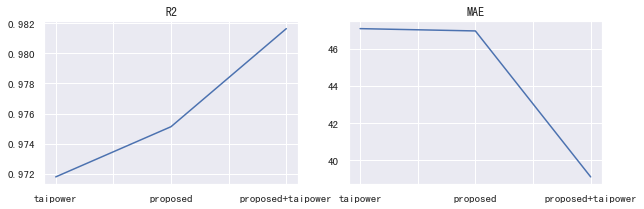

In [21]:
df_comparison = pd.DataFrame(data=[[R2_taipower,MSE_taipower],
                                   [R2_proposed, MSE_proposed],
                                   [R2_proposed_taipower, MSE_proposed_taipower]],
                             index=['taipower','proposed','proposed+taipower'],
                             columns=['R2','MAE'])

fig, ax = plt.subplots(1,2, figsize=(10,3))
df_comparison['R2'].plot(title='R2',ax=ax[0])
df_comparison['MAE'].plot(title='MAE',ax=ax[1])

## 6. Risk analysis

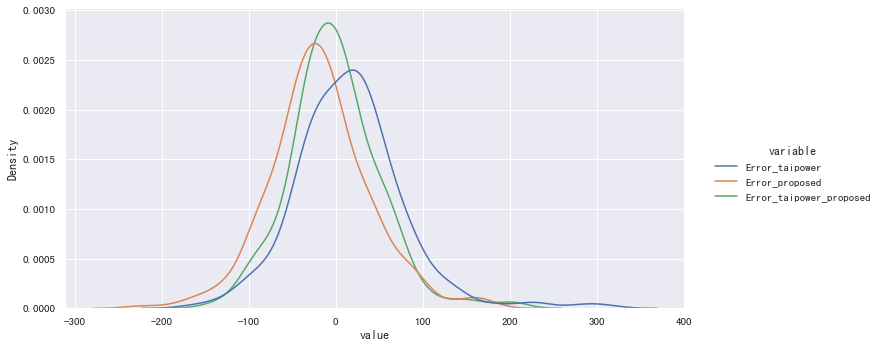

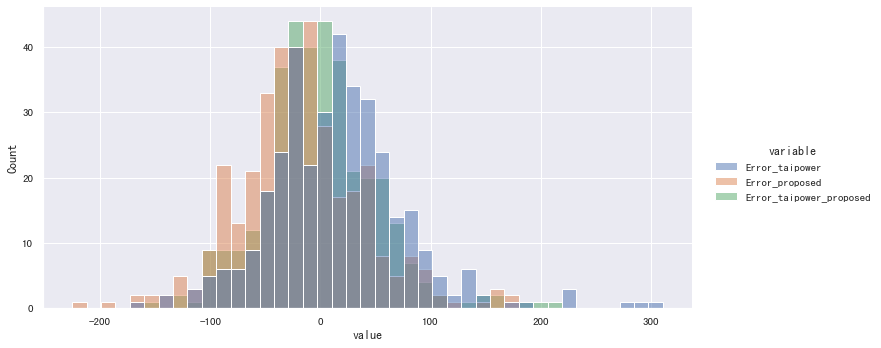

In [22]:
load_pred['Error_taipower'] = load_pred['預估瞬時尖峰負載(萬瓩)']-load_pred['peak_load_total']
load_pred['Error_proposed'] = load_pred['peak_load_total_pred']-load_pred['peak_load_total']
load_pred['Error_taipower_proposed'] = load_pred['peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)']-load_pred['peak_load_total']

sns.displot(data=load_pred[['Error_taipower','Error_proposed','Error_taipower_proposed']].melt(), 
            x='value', hue='variable', kind='kde', aspect=2)

sns.displot(data=load_pred[['Error_taipower','Error_proposed','Error_taipower_proposed']].melt(), 
            x='value', hue='variable', aspect=2)

In [23]:
load_pred[['Error_taipower','Error_proposed','Error_taipower_proposed']].describe()

,Error_taipower,Error_proposed,Error_taipower_proposed
count,359.000000,359.000000,359.000000
mean,15.812535,-18.333844,-1.260655
std,62.745295,57.932904,52.208707
min,-165.400000,-225.299083,-147.705472
25%,-22.150000,-50.220258,-33.509038
50%,16.000000,-21.250349,-3.509664
75%,46.450000,12.362046,25.123709
max,310.800000,177.756928,211.218941


### 6.1 Percentage threshold

In [24]:
threshold_percentage = 0.1

In [25]:
load_pred['load_supply'] = load_pred['預估淨尖峰供電能力(萬瓩)']
load_pred['Operating Reserve'] = load_pred['load_supply'] - load_pred['peak_load_total']
load_pred['Operating Reserve (%)'] = load_pred['Operating Reserve']/load_pred['peak_load_total']*100

load_pred[['Operating Reserve', 'Operating Reserve (%)']].describe()

,Operating Reserve,Operating Reserve (%)
count,359.000000,359.000000
mean,380.687187,11.880432
std,93.863497,2.966270
min,176.600000,5.575386
25%,307.300000,9.760632
50%,374.800000,11.585309
75%,443.900000,13.589586
max,648.500000,22.252747


In [26]:
for prediction_col in ['peak_load_total_pred','peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)']:

    load_pred['load_supply'] = load_pred[prediction_col] * (1+threshold_percentage)
    load_pred['Operating Reserve'] = load_pred['load_supply'] - load_pred['peak_load_total']
    load_pred['Operating Reserve (%)'] = load_pred['Operating Reserve']/load_pred['peak_load_total']*100

    print('prediction_col: '+prediction_col)
    display(load_pred[['Operating Reserve', 'Operating Reserve (%)']].describe())
    print('-------------------------------------------')

prediction_col: peak_load_total_pred


,Operating Reserve,Operating Reserve (%)
count,359.000000,359.000000
mean,302.719484,9.391551
std,71.369239,2.014742
min,95.516066,3.124401
25%,252.133782,8.259858
50%,295.709169,9.256151
75%,343.638370,10.437287
max,518.023226,16.888568


-------------------------------------------
prediction_col: peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)


,Operating Reserve,Operating Reserve (%)
count,359.000000,359.000000
mean,321.499993,9.978635
std,65.712784,1.826550
min,136.640026,5.399024
25%,275.693297,8.899882
50%,313.739028,9.895469
75%,366.306246,10.906547
max,522.295402,18.183320


-------------------------------------------


<AxesSubplot:>

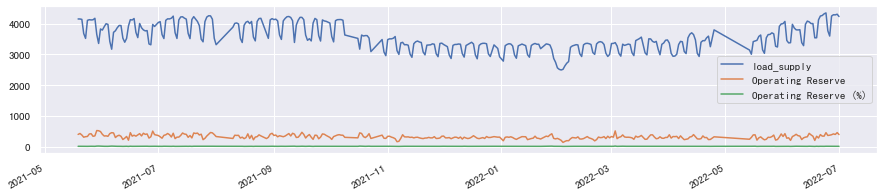

In [27]:
load_pred[['load_supply', 'Operating Reserve', 'Operating Reserve (%)']].plot(figsize=(15,3))

### 6.2 Constant threshold

In [28]:
threshold_const = 300

In [29]:
load_pred['load_supply'] = load_pred['預估淨尖峰供電能力(萬瓩)']
load_pred['Operating Reserve'] = load_pred['load_supply'] - load_pred['peak_load_total']
load_pred['Operating Reserve (%)'] = load_pred['Operating Reserve']/load_pred['peak_load_total']*100

load_pred[['Operating Reserve', 'Operating Reserve (%)']].describe()

,Operating Reserve,Operating Reserve (%)
count,359.000000,359.000000
mean,380.687187,11.880432
std,93.863497,2.966270
min,176.600000,5.575386
25%,307.300000,9.760632
50%,374.800000,11.585309
75%,443.900000,13.589586
max,648.500000,22.252747


In [30]:
for prediction_col in ['peak_load_total_pred','peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)']:

    load_pred['load_supply'] = load_pred[prediction_col] + threshold_const
    load_pred['Operating Reserve'] = load_pred['load_supply'] - load_pred['peak_load_total']
    load_pred['Operating Reserve (%)'] = load_pred['Operating Reserve']/load_pred['peak_load_total']*100

    print('prediction_col: '+prediction_col)
    display(load_pred[['Operating Reserve', 'Operating Reserve (%)']].describe())
    print('-------------------------------------------')

prediction_col: peak_load_total_pred


,Operating Reserve,Operating Reserve (%)
count,359.000000,359.000000
mean,281.666156,8.873124
std,57.932904,2.238290
min,74.700917,1.974961
25%,249.779742,7.528914
50%,278.749651,8.661035
75%,312.362046,10.007225
max,477.756928,17.213637


-------------------------------------------
prediction_col: peak_load_total_pred + 預估瞬時尖峰負載(萬瓩)


,Operating Reserve,Operating Reserve (%)
count,359.000000,359.000000
mean,298.739345,9.406837
std,52.208707,2.106407
min,152.294528,4.098897
25%,266.490962,8.035808
50%,296.490336,9.284052
75%,325.123709,10.534286
max,511.218941,18.005739


-------------------------------------------


<AxesSubplot:>

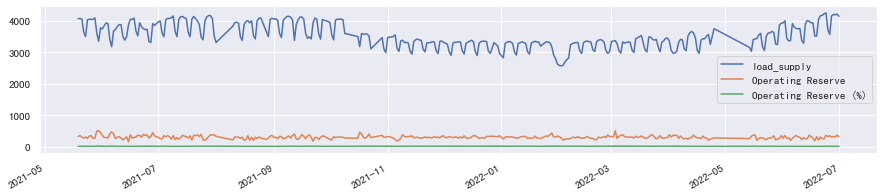

In [31]:
load_pred[['load_supply', 'Operating Reserve', 'Operating Reserve (%)']].plot(figsize=(15,3))